# Forcasting Tesla vc Ferari

In [14]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import itertools # library untuk iterasi
import plotly.express as px
import plotly.offline as py

from raceplotly.plots import barplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.api as sm

In [15]:
# import dataset
tesla = pd.read_csv('Tesla.csv')
ferari = pd.read_csv('Ferrari.csv')
print("Tesla")
print( tesla.info())
print()
print("Ferari")
print( ferari.info())

Tesla
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1885 non-null   object 
 1   Open       1885 non-null   float64
 2   High       1885 non-null   float64
 3   Low        1885 non-null   float64
 4   Close      1885 non-null   float64
 5   Adj Close  1885 non-null   float64
 6   Volume     1885 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 103.2+ KB
None

Ferari
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1885 non-null   object 
 1   Open       1885 non-null   float64
 2   High       1885 non-null   float64
 3   Low        1885 non-null   float64
 4   Close      1885 non-null   float64
 5   Adj Close  1885 non-null   float64
 6   Volume     1885 non-

In [16]:
# meerubah tipe data
tesla['Date']= pd.to_datetime(tesla['Date'],format="%Y-%m-%d")
ferari['Date']= pd.to_datetime(ferari['Date'],format="%Y-%m-%d")

# memberi label
tesla['Name'] = 'Tesla'
ferari['Name'] ='Ferari'

In [17]:
# mengabungkan 2 dataset menjadi 1
df = pd.concat([tesla, ferari])
df

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2015-10-22,14.104000,14.383333,13.960000,14.114667,14.114667,42378000,Tesla
1,2015-10-23,14.333333,14.356667,13.846000,13.939333,13.939333,63532500,Tesla
2,2015-10-26,14.092000,14.392000,14.000000,14.350667,14.350667,50871000,Tesla
3,2015-10-27,14.322667,14.473333,13.834000,14.023333,14.023333,52791000,Tesla
4,2015-10-28,14.087333,14.230000,13.886667,14.197333,14.197333,40929000,Tesla
...,...,...,...,...,...,...,...,...
1880,2023-04-13,283.000000,284.859985,279.720001,282.940002,282.940002,679800,Ferari
1881,2023-04-14,284.940002,286.609985,284.350006,285.529999,285.529999,462000,Ferari
1882,2023-04-17,280.619995,281.399994,277.920013,281.040009,281.040009,337500,Ferari
1883,2023-04-18,280.140015,281.640015,278.925995,280.600006,280.600006,309300,Ferari


## Share Value 2015-2023

In [18]:
# menmpilkan perbandingan kedua saham berdasarkan harga tertinggi
fig = px.line(df, x='Date', y='High', color='Name', color_discrete_sequence=['red','blue'],hover_data=['Low', 'Close','Adj Close', 'Volume'])

fig.show()


## Volume Comparison

In [19]:
# menmpilkan perbandingan kedua saham berdasarkan volume
fig = px.line(df, x='Date', y='Volume', color='Name', color_discrete_sequence=['red','blue'],hover_data=['Low', 'Close','Adj Close', 'Volume'])

fig.show()


## Race

In [20]:
# menampilkan hasil perbandingan berdasarkan price dari waktu ke waktu
color= {'Ferari': 'Red',
        'Tesla' : 'Blue'}

my_raceplot = barplot(df,
                      item_column='Name',
                      value_column='High',
                      time_column= 'Date')
my_raceplot.plot(title = 'Ferari Vs Tesla 2015-2023',
                 item_label = 'Company Names',
                 value_label='Share Price',
                 frame_duration= 50)

Karena dataset yang dimiliki adalah Saham maka dapat disimpulkan bahwa karakteristik time series adalah non-stationary.
Dikarenakan tujuan awal saya adalah untuk memprediksi pergerakan trend dari masing-masing saham maka saya akan menggunakan feature Close sebagai parameter analisa selanjutnya.

In [21]:
# menjadikan kolom date sebagai index
tesla.set_index('Date', inplace= True)
ferari.set_index('Date', inplace= True)

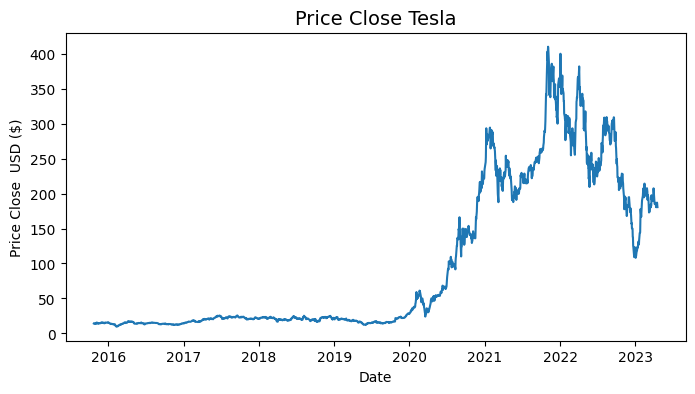

In [22]:
plt.figure(figsize=(8,4))
plt.title('Price Close Tesla',fontsize=14)
plt.plot(tesla['Close'])
plt.xlabel('Date')
plt.ylabel('Price Close  USD ($)')
plt.show()

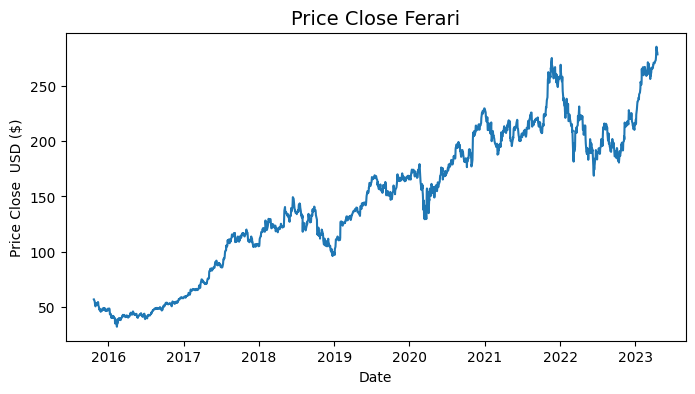

In [23]:
plt.figure(figsize=(8,4))
plt.title('Price Close Ferari',fontsize=14)
plt.plot(ferari['Close'])
plt.xlabel('Date')
plt.ylabel('Price Close  USD ($)')
plt.show()

Check For Stationery

In [24]:
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
  dftest = adfuller(dataset, autolag= 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ",dftest[1])
  print("3. Num Of Lags : ",dftest[2])
  print("4. Num Of Observations Used For ADF Regrssion and Critical Values Calculation : ", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
    print("\t",key, " : ",val)

In [25]:
def calculate_mae(actual, predicted):
    return np.mean(np.abs(actual - predicted))

def calculate_mape(actual, predicted):
    return 100 * np.mean(np.abs((actual - predicted) / actual))

def calculate_mad(data):
    return np.mean(np.abs(data - np.mean(data)))


In [26]:
ad_test(tesla['Adj Close'])

1. ADF :  -1.2790049694859702
2. P-Value :  0.638721999105065
3. Num Of Lags :  24
4. Num Of Observations Used For ADF Regrssion and Critical Values Calculation :  1860
5. Critical Values :
	 1%  :  -3.433870617038361
	 5%  :  -2.863095154794451
	 10%  :  -2.567597908717771


In [27]:
ad_test(ferari['Close'])

1. ADF :  -0.48920474064411995
2. P-Value :  0.8941059587398253
3. Num Of Lags :  24
4. Num Of Observations Used For ADF Regrssion and Critical Values Calculation :  1860
5. Critical Values :
	 1%  :  -3.433870617038361
	 5%  :  -2.863095154794451
	 10%  :  -2.567597908717771


Setelah dilakukan pengecekan dapat dilihat bahwa nilai ADF lebih positif dibanding Critical Values dan P-Values lebih tinggi dibanding nilai standar yang biasa digunakan yaitu (0.05), maka Data yang saya miliki tidak dapat menolak hipotesis 0. Yang artinya data yang saya miliki adalah berkarakteristik Non-Stationery.

## Tesla

In [28]:
# melakukan transfomasi logaritmik
tesla = tesla. drop (columns= 'Name', axis=1)
tesla = np.log(tesla)

<Axes: xlabel='Date'>

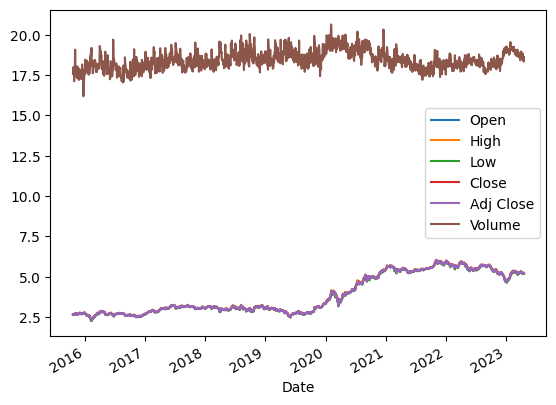

In [29]:
tesla.plot()

Melakukan Differencing

<Axes: xlabel='Date'>

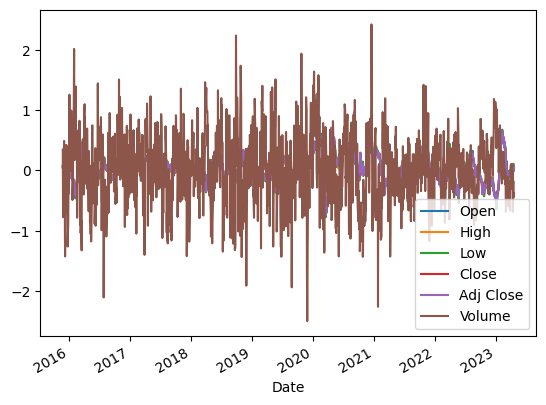

In [30]:
tesla_diff = tesla.diff(periods=24).dropna()
tesla_diff.plot()

Figure Out Order for ARIMA Model

In [33]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [34]:
tesla_model_fit = auto_arima(tesla_diff['Close'], trace =True,
                             suppress_warnings=True)
tesla_model_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-5821.392, Time=4.94 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-767.928, Time=1.36 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-5794.520, Time=0.69 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2686.425, Time=4.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-717.834, Time=0.47 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-5805.569, Time=4.75 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-5791.529, Time=9.27 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-5826.841, Time=13.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-5836.584, Time=12.41 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-5806.997, Time=3.76 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-5808.729, Time=12.33 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-5792.529, Time=1.06 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-5813.728, Time=1.92 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-5831.874, Time=11.09 sec
 ARIMA(3,0,1)(0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1861
Model:               SARIMAX(3, 0, 1)   Log Likelihood                2924.292
Date:                Sat, 28 Oct 2023   AIC                          -5836.584
Time:                        03:41:53   BIC                          -5803.411
Sample:                             0   HQIC                         -5824.359
                               - 1861                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.000      1.618      0.106   -5.31e-05       0.001
ar.L1          1.8227      0.034     52.988      0.000       1.755       1.890
ar.L2         -0.7537      0.052    -14.520      0.000      -0.855      -0.652
ar.L3         -0.0768      0.021     -3.659      0.000      -0.118      -0.036
ma.L1         -0.8735      0.029    -29.964      0.000      -0.931      -0.816
sigma2         0.0025   5.29e-05     47.653      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               771.91
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.10   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
train_tesla = tesla_diff.iloc[: -377] # pebandingan 80:20
test_tesla = tesla_diff.iloc[-377 :]
print(train_tesla.shape, test_tesla.shape)

(1484, 6) (377, 6)


Train the Model

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_tesla = SARIMAX(tesla_diff['Close'],
                      exog=tesla_diff[['Open','High','Low','Volume','Adj Close']],
                      order=(3, 0, 1),
                      seasonal_order=(0, 0, 0, 0))
result_tesla = model_tesla.fit()


In [37]:
print(result_tesla.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1861
Model:               SARIMAX(3, 0, 1)   Log Likelihood               19714.121
Date:                Sat, 28 Oct 2023   AIC                         -39408.241
Time:                        03:41:58   BIC                         -39352.953
Sample:                             0   HQIC                        -39387.867
                               - 1861                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Open        -4.95e-16         -0        inf      0.000   -4.95e-16   -4.95e-16
High        3.374e-16         -0       -inf      0.000    3.37e-16    3.37e-16
Low         5.691e-16   1.59e-27   3.58e+11      0.0

Make time Series Predictions

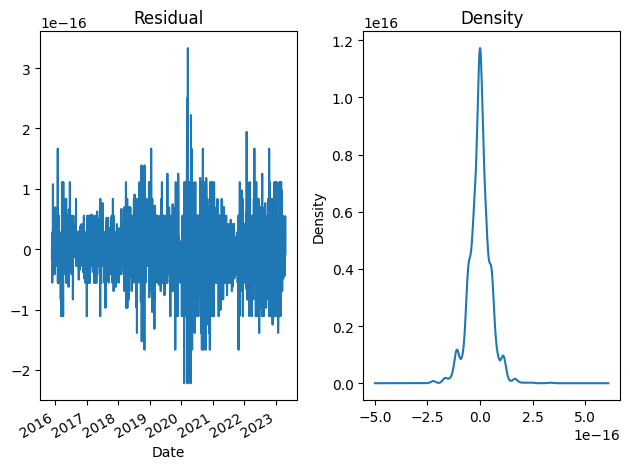

In [38]:
residual = result_tesla.resid[1:]
fig, ax =plt.subplots(1,2)
residual.plot(title='Residual', ax=ax[0])
residual.plot(title='Density',kind='kde',ax=ax[1])
plt.tight_layout()
plt.show()

Setelah dilakukan transformasi logaritmik dan differencing, kareakteristik dataset sudah kembali menjadi stationery. Dengan residual yang tersebar acak dan berskew normal diantara 0. Hal ini dapat dibuktikan dengan hasil Heteroskedasticity yang cukup rendah di nilai 2.22

Make Predictions on Test set

<Axes: xlabel='Date'>

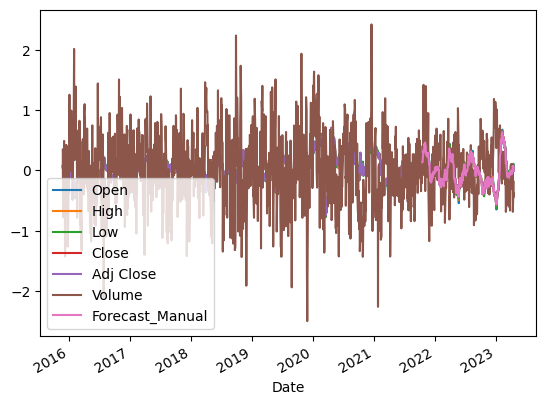

In [39]:
exog_data=test_tesla[['Open','High','Low','Volume','Adj Close']]

forecast_test = result_tesla.forecast(len(test_tesla), exog=exog_data)
tesla_diff['Forecast_Manual'] = [None]* len(train_tesla) + list(forecast_test)
tesla_diff.plot()

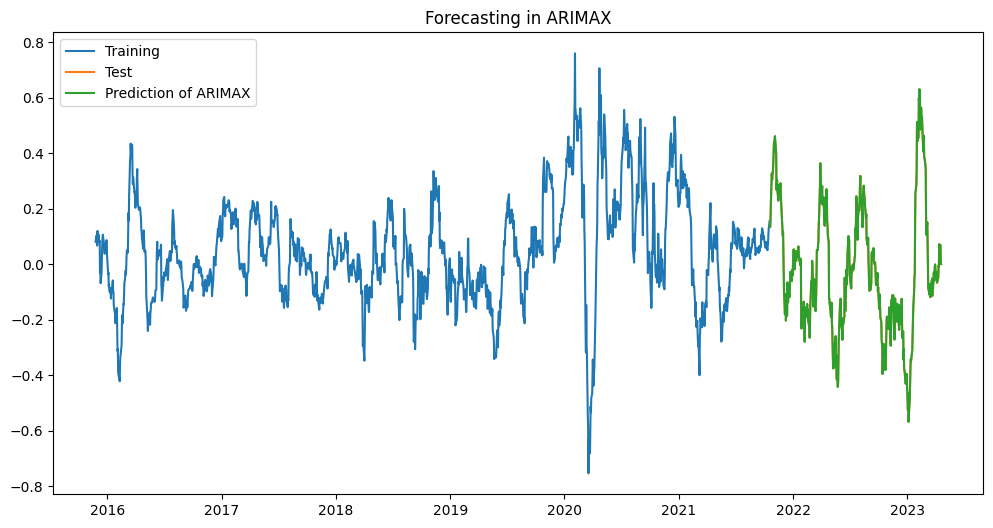

In [40]:
start = len(train_tesla)
end = len(train_tesla) + len(test_tesla) - 1
exog_data1=tesla_diff[['Open','High','Low','Volume','Adj Close']]
predictions_arimax = result_tesla.predict(start = start,
                                              end = end,
                                              exog = exog_data1)
# Plot SARIMAX
plt.figure(figsize=(12, 6))
plt.plot(train_tesla["Close"], label = "Training")
plt.plot(test_tesla["Close"], label = "Test")
plt.plot(test_tesla.index, predictions_arimax, label = "Prediction of ARIMAX")
plt.legend()
plt.title("Forecasting in SARIMAX")
plt.show()


Cross Cek RMSE, MAPE, MAD, MAE

In [41]:
calculate_mae(tesla_diff['Close'], predictions_arimax) # Hasil MAE bagus

4.245471127612735e-17

In [42]:
calculate_mape(tesla_diff['Close'], predictions_arimax) # Hasil Prediksi sangat akurat

8.946901907864759e-14

In [43]:
calculate_mad(tesla_diff['Close']) # Nilai MAD yang lebih kecil menunjukkan bahwa model melakukan peramalan yang lebih baik

0.15007546195198765

In [44]:
rmse = np.sqrt(mean_squared_error(predictions_arimax, test_tesla['Close']))
rmse

5.702272615063238e-17

## Ferari

<Axes: xlabel='Date'>

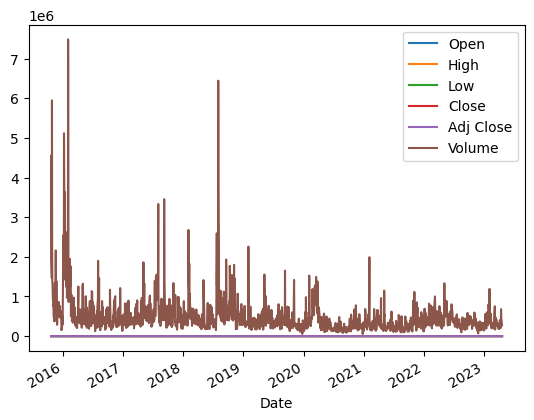

In [45]:
ferari.plot()

In [46]:
ad_test(ferari['Close'])

1. ADF :  -0.48920474064411995
2. P-Value :  0.8941059587398253
3. Num Of Lags :  24
4. Num Of Observations Used For ADF Regrssion and Critical Values Calculation :  1860
5. Critical Values :
	 1%  :  -3.433870617038361
	 5%  :  -2.863095154794451
	 10%  :  -2.567597908717771


In [47]:
ad_test(ferari['Open'])

1. ADF :  -0.2730389053492193
2. P-Value :  0.9292369819324027
3. Num Of Lags :  3
4. Num Of Observations Used For ADF Regrssion and Critical Values Calculation :  1881
5. Critical Values :
	 1%  :  -3.4338312580685653
	 5%  :  -2.863077778972339
	 10%  :  -2.5675886567541726


In [48]:
ad_test(ferari['High'])

1. ADF :  -0.42724258770728946
2. P-Value :  0.9054499141999346
3. Num Of Lags :  14
4. Num Of Observations Used For ADF Regrssion and Critical Values Calculation :  1870
5. Critical Values :
	 1%  :  -3.433851764270508
	 5%  :  -2.863086831883029
	 10%  :  -2.5675934770796993


In [49]:
ad_test(ferari['Low'])

1. ADF :  -0.30114213776846666
2. P-Value :  0.9253424154854277
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regrssion and Critical Values Calculation :  1884
5. Critical Values :
	 1%  :  -3.433825707083533
	 5%  :  -2.8630753283581076
	 10%  :  -2.567587351898432


In [50]:
ad_test(ferari['Volume'])

1. ADF :  -5.795886323323207
2. P-Value :  4.753259482217901e-07
3. Num Of Lags :  15
4. Num Of Observations Used For ADF Regrssion and Critical Values Calculation :  1869
5. Critical Values :
	 1%  :  -3.4338536404563853
	 5%  :  -2.863087660163165
	 10%  :  -2.5675939181074106


In [51]:
ad_test(ferari['Adj Close'])

1. ADF :  -0.4352612358888755
2. P-Value :  0.9040428631656607
3. Num Of Lags :  24
4. Num Of Observations Used For ADF Regrssion and Critical Values Calculation :  1860
5. Critical Values :
	 1%  :  -3.433870617038361
	 5%  :  -2.863095154794451
	 10%  :  -2.567597908717771


Dari hasil pengecekan ADF didapat pada feature volume memiliki karakteristik satationery. Sama hal nya denga saham tesla maka untuk melanjutkan pemprosesan maka akan dilakukan langkah yang sama seperti saham tesla. Untuk panjang lag saya menggunakan 24 hasil lag dari feature Close sesuai denga tujuan awal analisa.

In [52]:
# melakukan tranformasi logaritmik dan differencing
ferari = ferari.drop(columns='Name', axis=1)
ferari = np.log(ferari)


<Axes: xlabel='Date'>

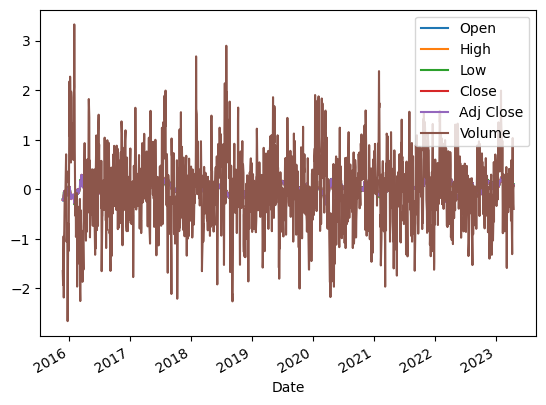

In [53]:
ferari_diff = ferari.diff(periods=24).dropna()
ferari_diff.plot()

Figure Out Order for ARIMA Model

In [54]:
ferari_model_fit = auto_arima(ferari_diff['Close'],trace = True,
                              suppress_warnings=True)
ferari_model_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-8158.039, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-3714.447, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-8144.220, Time=0.35 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-5548.022, Time=1.71 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3612.016, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-8160.163, Time=1.42 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-6469.638, Time=3.21 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-8146.624, Time=1.35 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-8158.124, Time=1.18 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-7101.598, Time=2.73 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-8150.019, Time=3.32 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-8169.495, Time=7.25 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-8159.350, Time=6.18 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=-8194.726, Time=6.49 sec
 ARIMA(1,0,4)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1861
Model:               SARIMAX(2, 0, 4)   Log Likelihood                4106.086
Date:                Sat, 28 Oct 2023   AIC                          -8198.172
Time:                        03:43:31   BIC                          -8159.470
Sample:                             0   HQIC                         -8183.910
                               - 1861                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0910      0.020      4.470      0.000       0.051       0.131
ar.L2          0.8511      0.019     45.667      0.000       0.815       0.888
ma.L1          0.8481      0.026     32.794      0.000       0.797       0.899
ma.L2          0.0179      0.027      0.654      0.513      -0.036       0.071
ma.L3          0.0526      0.030      1.727      0.084      -0.007       0.112
ma.L4         -0.0791      0.023     -3.463      0.001      -0.124      -0.034
sigma2         0.0007    1.5e-05     46.964      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               706.92
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.06
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
train_ferari = ferari_diff.iloc[:-377]
test_ferari = ferari_diff.iloc[-377:]

Train to Model

In [56]:
model_ferari = SARIMAX(ferari_diff['Close'],
                       exog = ferari_diff[['Open','High','Low','Volume','Adj Close']],
                       order = (2,0,4),
                      seasonal_order=(0,0,0,0))
result_ferari = model_ferari.fit()
print(result_ferari.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1861
Model:               SARIMAX(2, 0, 4)   Log Likelihood               10609.568
Date:                Sat, 28 Oct 2023   AIC                         -21195.136
Time:                        03:43:45   BIC                         -21128.790
Sample:                             0   HQIC                        -21170.686
                               - 1861                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Open          -0.0058      0.001     -4.033      0.000      -0.009      -0.003
High           0.0099      0.002      4.930      0.000       0.006       0.014
Low            0.0058      0.003      2.264      0.0

Make time Series Predictions

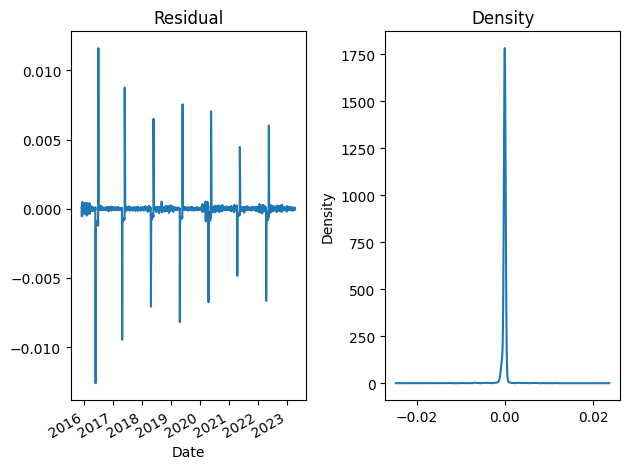

In [57]:
residual_f = result_ferari.resid[1:]
fiq, ax = plt.subplots(1,2)
residual_f.plot(title = 'Residual', ax=ax[0])
residual_f.plot(title = 'Density',kind='kde', ax=ax[1])
plt.tight_layout()

Dari Grafik terlihat bahwa nilai kurtosius cukup tinggi ini mengindikasi kemungkinan terdapat outlier. terlihat pada grafik dimana nilai outlier sekitar -0.1 sedangkan data terdistibusi di range 0.

<Axes: xlabel='Date'>

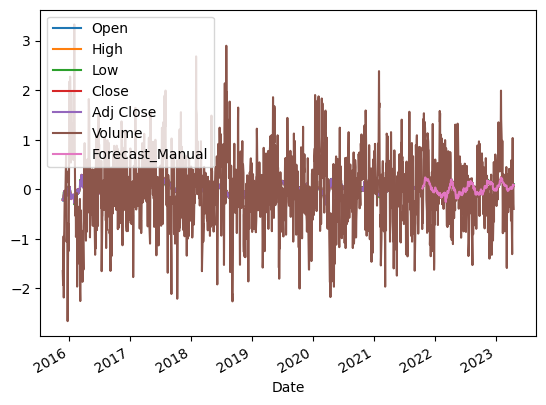

In [58]:
exog_data=test_ferari[['Open','High','Low','Volume','Adj Close']]

forecast_test = result_ferari.forecast(len(test_ferari), exog=exog_data)
ferari_diff['Forecast_Manual'] = [None]* len(train_ferari) + list(forecast_test)
ferari_diff.plot()

Make Predict on Test data

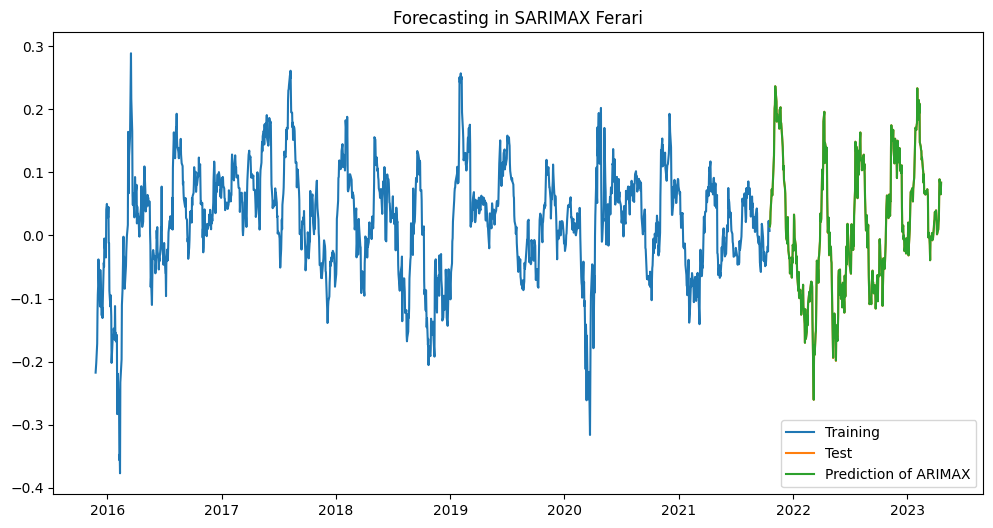

In [59]:
start = len(train_ferari)
end = len(train_ferari) + len(test_ferari) - 1
exog_data1=ferari_diff[['Open','High','Low','Volume','Adj Close']]
predictions_arimax = result_ferari.predict(start = start,
                                              end = end,
                                              exog = exog_data1)
# Plot SARIMAX
plt.figure(figsize=(12, 6))
plt.plot(train_ferari["Close"], label = "Training")
plt.plot(test_ferari["Close"], label = "Test")
plt.plot(test_ferari.index, predictions_arimax, label = "Prediction of ARIMAX")
plt.legend()
plt.title("Forecasting in SARIMAX Ferari")
plt.show()


Cross Cek RMSE, MAPE, MAD, MAE

In [60]:
calculate_mae(ferari_diff['Close'], predictions_arimax) # Hasil MAE bagus

0.0001604227855270597

In [61]:
calculate_mape(ferari_diff['Close'], predictions_arimax) # Hasil Prediksi sangat akurat

3.8210337078182532

In [62]:
calculate_mad(ferari_diff['Close']) # Nilai MAD yang lebih kecil menunjukkan bahwa model melakukan peramalan yang lebih baik

0.0696915882770866

In [64]:
rmse = np.sqrt(mean_squared_error(predictions_arimax, test_ferari['Close']))
rmse

0.0005467041710379838